In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [60]:
pi_b_waypoints = [(1, 2), (7, 4), (3, 6), (6, 8), (10, 10)]
pi_blackbox_waypoints = [(1, 2), (2, 4), (3, 6), (6, 8), (10, 10)]
def pi(s, waypoints):
    s_x, s_y = s
    wp_x, wp_y = waypoints[int(s_y / 2)]
    a_x = wp_x - s_x
    a_y = wp_y - s_y   
    return (a_x / np.sqrt(a_x**2 + a_y**2), a_y / np.sqrt(a_x**2 + a_y**2))

In [41]:
def plot_policy(waypoints):
    plt.axis([0, 10, 0, 10])
    for (x, y) in waypoints:
        plt.plot(x, y, 'bo')
    for i in np.arange(0.0, 10.0, 0.5):
        for j in np.arange(0, 10.0, 0.5):
            dx, dy = pi((i, j), waypoints)
            plt.arrow(i, j, dx, dy, head_width=0.2, head_length=0.5, fc='k', ec='k')
    plt.show()

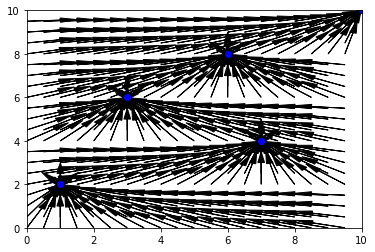

In [42]:
plot_policy(pi_b_waypoints)

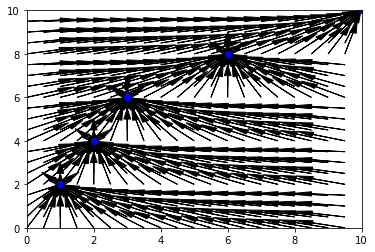

In [47]:
plot_policy(pi_blackbox_waypoints)

In [59]:
def generate_trajectories(waypoints, iters):
    trajectories = []
    for iter in range(iters):
        single_trajectory = []
        x = np.random.uniform(low=0.0, high=10.0)
        y = np.random.uniform(low=0.0, high=10.0)
        for i in range(50):
            if (x > 10 or y > 10):
                break
            dx, dy = pi((x, y), waypoints)
            single_trajectory.append([x, y, dx, dy])
            x += dx
            y += dy
        trajectories.append(single_trajectory)
    return np.asarray(trajectories)

In [61]:
pi_b_trajectories = generate_trajectories(pi_b_waypoints, 50)
np.shape(pi_b_trajectories)

(50,)

In [62]:
pi_blackbox_trajectories = generate_trajectories(pi_blackbox_waypoints, 50)
np.shape(pi_blackbox_trajectories)

(50,)

In [64]:
def is_same_action(dx1, dy1, dx2, dy2, epsilon):
    return (int(np.absolute(dx1 - dx2) < epsilon and np.absolute(dy1 - dy2) < epsilon))

In [67]:
def sample_from_policies(iters, epsilon):
    full_data = []
    Xs = []
    ys = []
    for iter in range(iters):
        x = np.random.uniform(low=0.0, high=10.0)
        y = np.random.uniform(low=0.0, high=10.0)
        pi_b_dx, pi_b_dy = pi((x, y), pi_b_waypoints)
        pi_blackbox_dx, pi_blackbox_dy = pi((x, y), pi_blackbox_waypoints)
        is_same = is_same_action(pi_b_dx, pi_b_dy, pi_blackbox_dx, pi_blackbox_dy, epsilon)
        full_data.append([x, y, pi_b_dx, pi_b_dy, pi_blackbox_dx, pi_blackbox_dy, is_same])
        Xs.append([x, y, pi_b_dx, pi_b_dy])
        ys.append(is_same)
    return (np.asarray(full_data), np.asarray(Xs), np.asarray(ys))

In [89]:
full_data, X, y = sample_from_policies(100000, 0.05)

In [90]:
np.count_nonzero(y)/100000

0.80526

In [91]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=42)

In [92]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10, random_state=0)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.9998

In [98]:
from sklearn.tree import DecisionTreeClassifier
decisiontree = DecisionTreeClassifier(random_state=0, max_depth = 3)
decisiontree.fit(X_train, y_train)
decisiontree.score(X_test, y_test)

0.9988

In [ ]:
# 1 means that the actions are roughly the same, 0 means different

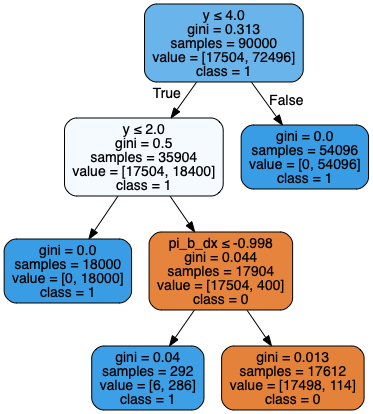

In [99]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(decisiontree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = ['x', 'y', 'pi_b_dx', 'pi_b_dy'],class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('decisiontree.png')
Image(graph.create_png())

In [94]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(random_state=0, solver='lbfgs')
logistic.fit(X_train, y_train)
logistic.score(X_test, y_test)

0.9062